In [1]:
from itertools import count
from operator import itemgetter
from functools import partial


import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib import cm
from matplotlib.colors import ListedColormap
import sympy
import kwant
import qsymm
import kwant.qsymm
import tinyarray
import adaptive
from bokeh.io import output_notebook
from adaptive.notebook_integration import ensure_holoviews


from common import invariant_Z4, ham_function

## Generate general $C_4 \mathcal{T}$ Hamiltonian

### Construct atomic limits

In [2]:
# Define necessary matrices
eye = sympy.Matrix([[1, 0], [0, 1]])
sigma_x = sympy.Matrix([[0, 1], [1, 0]])
sigma_y = sympy.Matrix([[0, -1j], [1j, 0]])
sigma_z = sympy.Matrix([[1, 0], [0, -1]])

alpha = beta = 0

# Define operators
cos, sin = sympy.cos, sympy.sin
T = (eye + cos(beta) * sigma_z + sin(beta) * sigma_x) / 2
spin_flip = (sigma_z + 1j * (cos(alpha) * sigma_y + sin(alpha) * sigma_x)) / 2
orbital_h = sympy.kronecker_product(T, spin_flip)
k_x, k_y = k = sympy.sympify("k_x, k_y")


def hop_k_space(dr):
    return sympy.exp(1j * (k_x * dr[0] + k_y * dr[1]))


# Define desired C4T
C4T = qsymm.rotation(1 / 4, spin=1 / 2) * qsymm.time_reversal(2, spin=1 / 2)
# Add orbital rotation matrix
C4T.U = np.kron([[0, -1j], [1j, 0]], C4T.U)
np.testing.assert_array_almost_equal((C4T**4).U, -np.identity(4))

# Generate Hamiltonians
max_Wyckoff = np.array([[0, 0], [1, 0], [1, 1], [0, 1]])

hamiltonians = [
    sum(
        (C4T**i).apply(qsymm.Model(hop_k_space(dr) * orbital_h, momenta=k))
        for i in range(4)
    )
    for dr in max_Wyckoff
]

# Confirm that all Hamiltonians have flat band spectrum by checking
# at a random k
for h in hamiltonians:
    try:
        h_k = h.lambdify()(*np.random.randn(2))
    except TypeError:
        h_k = h.lambdify()()

    np.testing.assert_allclose(np.linalg.eigvalsh(h_k), [-1, -1, 1, 1])

### Add atomic limits

In [3]:
# Generate letters and symbols to construct general model
coeffs = list(sympy.symbols("alpha, beta, gamma"))


def l_i():
    for i in count():
        yield sympy.Symbol(f"lambda_{i}")


coeffs_symm_breaking = l_i()

# Combine all atomic limits into one Hamiltonian
# H_1 = -H_3, so we omit the last one
h_limits = sum(h * coeff for h, coeff in zip(hamiltonians, coeffs))

h_limits.tosympy()

Matrix([
[alpha*(1.0 - 6.12323399573676e-17*I) + 0.5*beta*e**(1.0*I*k_x) + beta*(0.5 - 6.12323399573676e-17*I)/e**(1.0*I*k_x) + 0.5*e**(1.0*I*k_x)*e**(1.0*I*k_y)*gamma + gamma*(0.5 - 6.12323399573676e-17*I)/(e**(1.0*I*k_x)*e**(1.0*I*k_y)), alpha*(1.11022302462516e-16 - 1.60812264967664e-16*I) + 0.5*beta*e**(1.0*I*k_x) + beta*(-0.5 - 1.60812264967664e-16*I)/e**(1.0*I*k_x) + 0.5*e**(1.0*I*k_x)*e**(1.0*I*k_y)*gamma + gamma*(-0.5 - 1.60812264967664e-16*I)/(e**(1.0*I*k_x)*e**(1.0*I*k_y)),                                                                                                                                                                                                                                                                                                           0,                                                                                                                                                                                                                   

### Ensure only $C_4 \mathcal{T}$ is preserved

In [4]:
# Find all terms that preserve C4T
norbs = [("A", 4)]  # A atom per unit cell, 4 orbitals each
hopping_vectors = [("A", "A", [0, 1]), ("A", "A", [1, 0])]
family = qsymm.bloch_family(hopping_vectors, [C4T], norbs)

# Break any additional symmetries and obtain final general model
h_only_C4T = h_limits + sum(
    [symbol * term for symbol, term in zip(coeffs_symm_breaking, family)]
)
h_only_C4T.tosympy(nsimplify=True)

Matrix([
[                                                                                 alpha*(1 - 612323399573677*I/10000000000000000000000000000000) + beta*e**(1.0*I*k_x)/2 + beta*(1/2 - 612323399573677*I/10000000000000000000000000000000)/e**(1.0*I*k_x) + e**(I*k_x)*lambda_4 + e**(1.0*I*k_x)*e**(1.0*I*k_y)*gamma/2 + e**(I*k_y)*lambda_13 + lambda_0 + lambda_13/e**(I*k_y) + gamma*(1/2 - 612323399573677*I/10000000000000000000000000000000)/(e**(1.0*I*k_x)*e**(1.0*I*k_y)) + lambda_4/e**(I*k_x), alpha*(27755575615629/250000000000000000000000000000 - 10050766560479*I/62500000000000000000000000000) + beta*e**(1.0*I*k_x)/2 + beta*(-1/2 - 10050766560479*I/62500000000000000000000000000)/e**(1.0*I*k_x) + I*e**(I*k_x)*lambda_14 + e**(I*k_x)*lambda_5 + e**(1.0*I*k_x)*e**(1.0*I*k_y)*gamma/2 - I*e**(I*k_y)*lambda_12 + e**(I*k_y)*lambda_19 + I*lambda_12/e**(I*k_y) - lambda_19/e**(I*k_y) + gamma*(-1/2 - 10050766560479*I/62500000000000000000000000000)/(e**(1.0*I*k_x)*e**(1.0*I*k_y)) - I*lambda_14/e*

## Test model

### Check that each AL is labeled by a different integer

In [5]:
# Building kwant system for model
syst = kwant.qsymm.model_to_builder(
    h_only_C4T, norbs=[("A", 4)], lat_vecs=np.eye(2), atom_coords=[(0, 0)]
)
syst_wrapped = kwant.wraparound.wraparound(syst).finalized()

# Define parameters dictionary
def parameters(alpha, beta, symm_breaking):
    coeffs_symm_breaking = l_i()
    params = {
        str(d_i): value
        for d_i, value in zip(l_i(), symm_breaking * np.ones(len(family)))
    }
    params["alpha"] = alpha
    params["beta"] = beta
    params["gamma"] = 1 - np.abs(beta) - np.abs(alpha)
    return params


# Create four different phases
symm_breaking = 0.01
limits_params = [
    parameters(0.6, 0.2, symm_breaking),  # nu = 0
    parameters(0.2, 0.2, symm_breaking),  # nu = 2
    parameters(0.2, 0.6, symm_breaking),  # nu = 1
    parameters(0.2, -0.6, symm_breaking),  # nu = 3
]

# Test invariant
for params, nu_expected in zip(limits_params, np.array([0, 2, 1, 3])):
    nu_calculated = invariant_Z4(C4T.U, ham_function(syst, params), N=20)[0]
    assert np.isclose(nu_calculated, nu_expected, atol=1e-8), nu_calculated

### Create finite size systems and compute charge densities

In [14]:
# Create systems
def rhombus_shape(L):
    return lambda site: np.linalg.norm(site.pos, 1) <= L * np.sqrt(2)


def square_shape(L):
    return lambda site: np.linalg.norm(site.pos, float("inf")) <= L


def create_syst(template, L, shape_function):
    syst = kwant.Builder()
    syst.fill(template, shape=shape_function(L), start=(0, 0))
    sysf = syst.finalized()
    return sysf


L = 3
systems = [create_syst(syst, L, shape) for shape in [square_shape, rhombus_shape]]

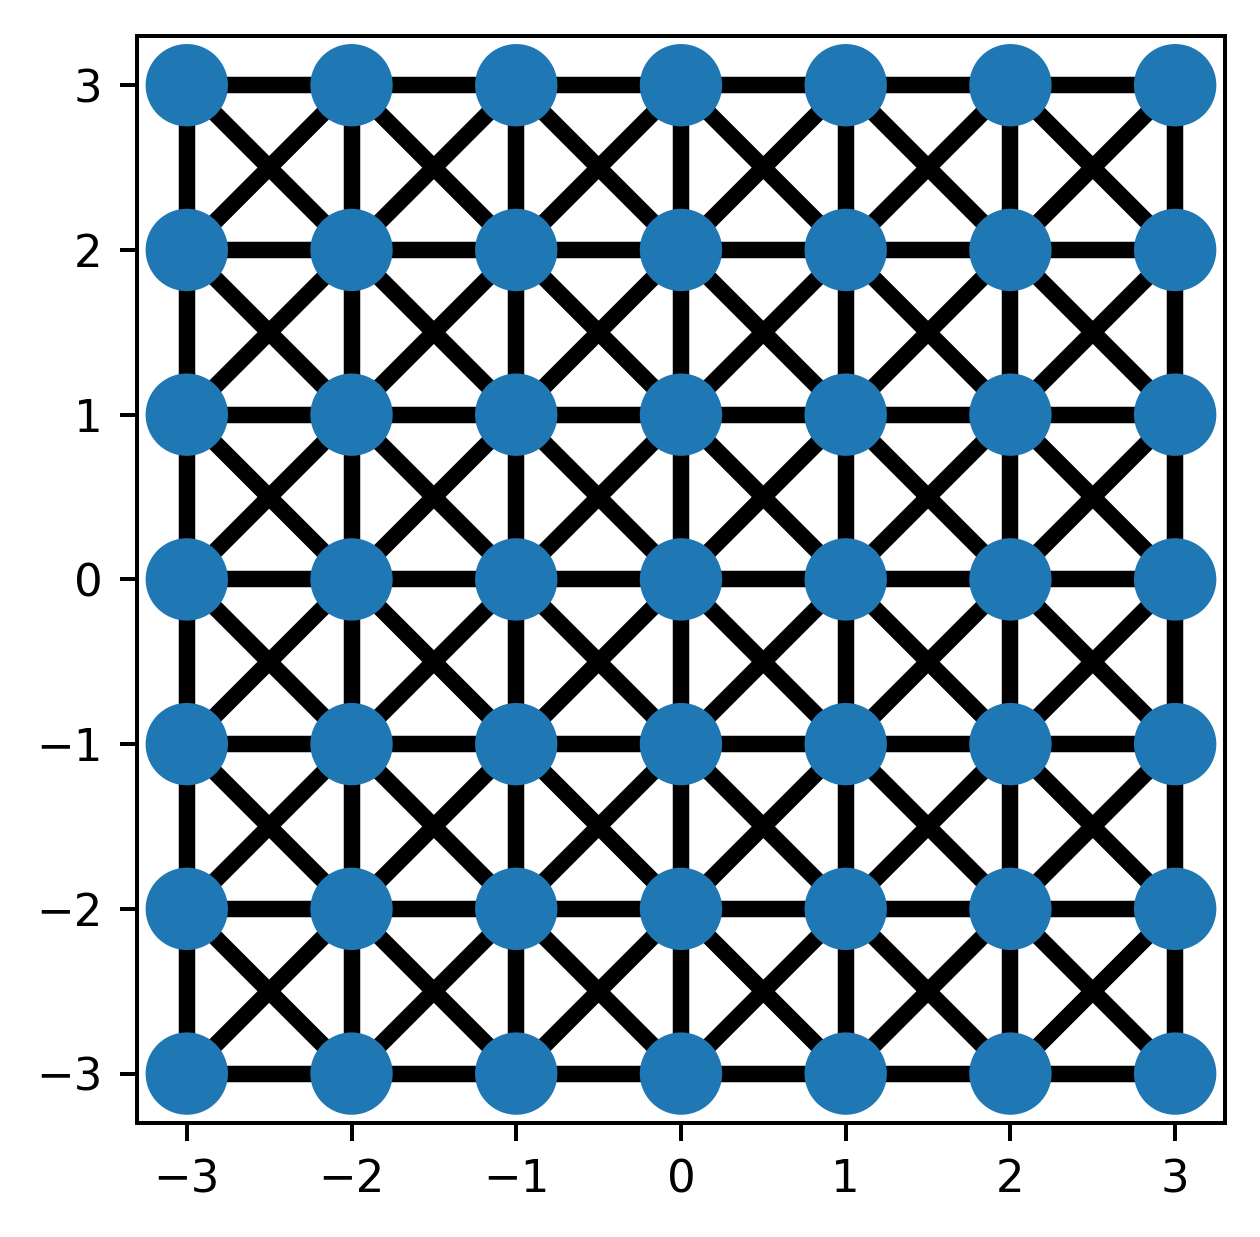

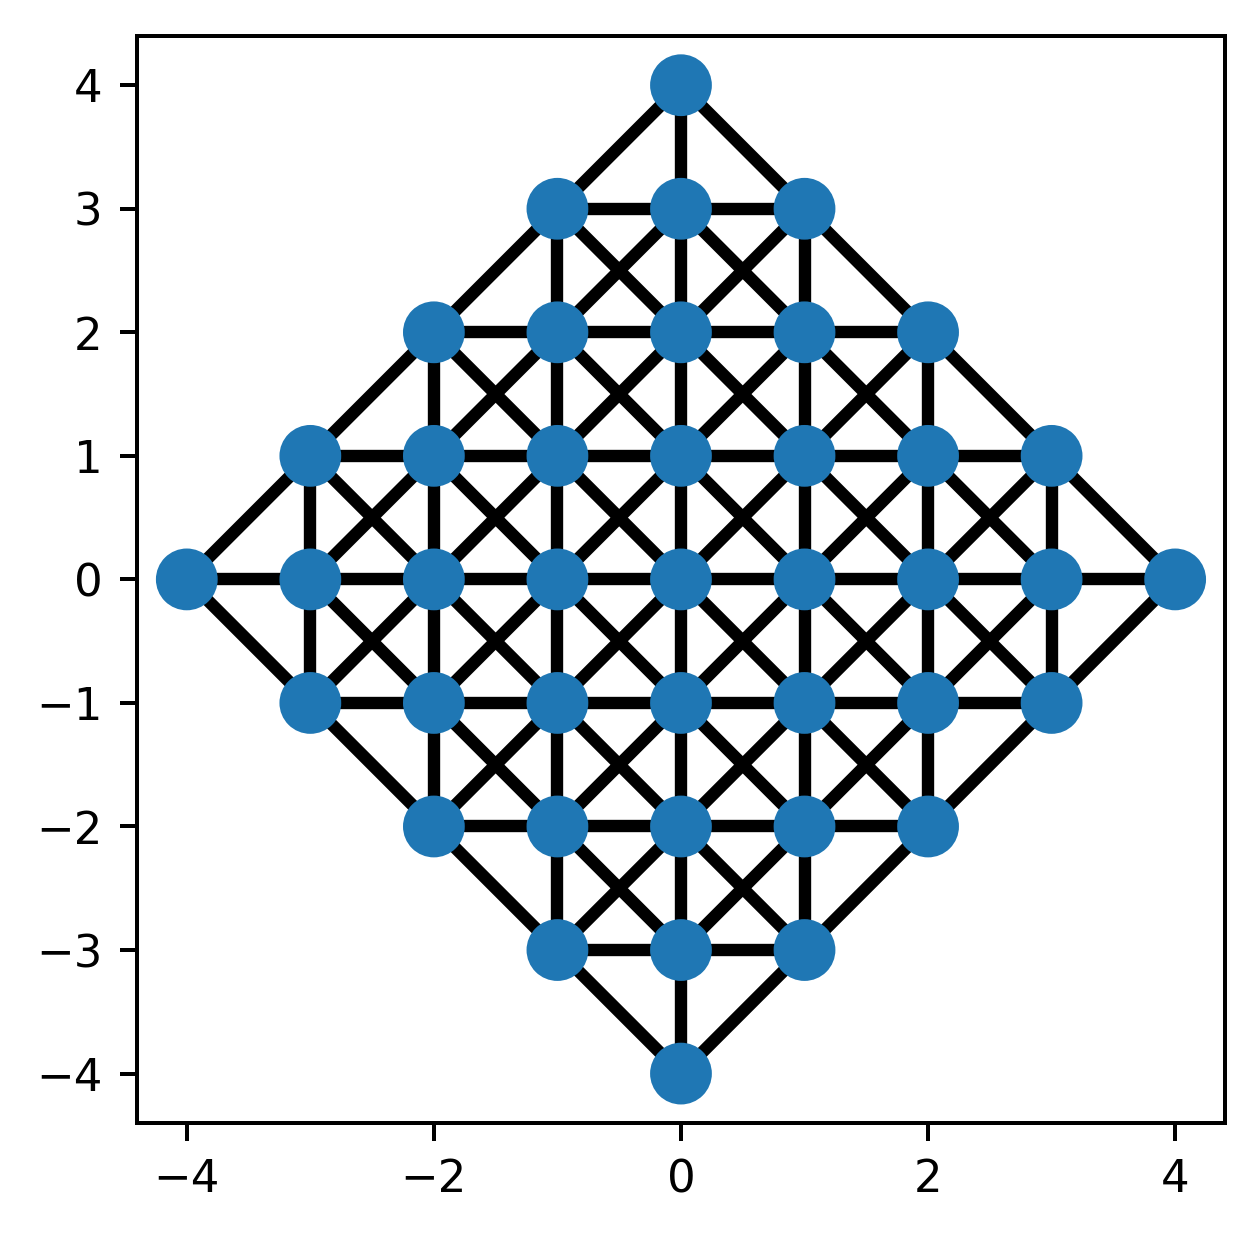

In [15]:
kwant.plotter.plot(systems[0])
kwant.plotter.plot(systems[1]);

In [16]:
E_F = 0.15

densities = []
for params in limits_params:
    for sysf in systems:
        vals, vecs = np.linalg.eigh(sysf.hamiltonian_submatrix(params=params))
        density = kwant.operator.Density(sysf, sum=False)
        density_dist = np.sum([density(v) for v in vecs[:, vals < E_F].T], axis=0)
        densities.append(density_dist)

### Plot charge densities

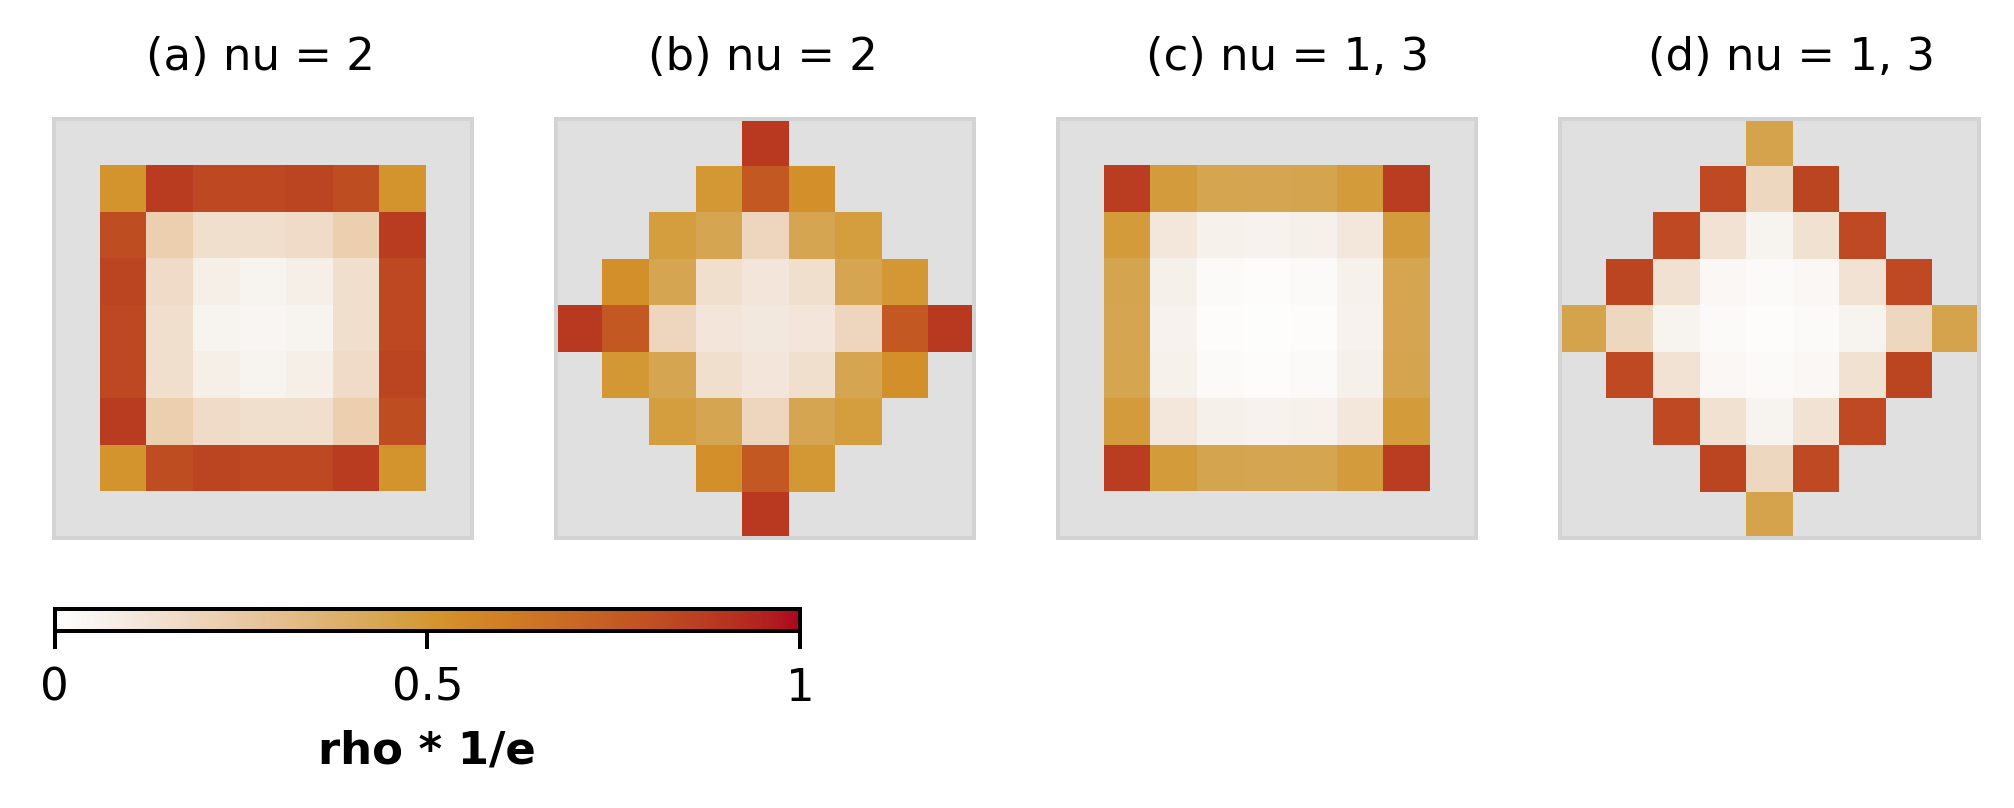

In [17]:
font = {"size": 9}
matplotlib.rc("font", **font)
matplotlib.rcParams["figure.dpi"] = 72 * 5
# matplotlib.rcParams["text.usetex"] = True

texts1 = [
    "(a) nu = 2",
    "(b) nu = 2",
    "(c) nu = 1, 3",
    "(d) nu = 1, 3",
]
xspaces1 = [0.22, 0.22, 0.21, 0.21]

fig1, axis1 = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(6.9, 2))

for i, txt, xspace in zip(np.arange(2, 6), texts1, xspaces1):
    ax = axis1[i - 2]
    kwant.plotter.map(
        systems[i % 2], densities[i] - 2, oversampling=1, vmin=0, vmax=1, ax=ax
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["bottom"].set_color("lightgrey")
    ax.spines["top"].set_color("lightgrey")
    ax.spines["left"].set_color("lightgrey")
    ax.spines["right"].set_color("lightgrey")

    ax.text(xspace, 1.12, txt, transform=ax.transAxes, fontsize=9)

fig1.subplots_adjust(bottom=0.1)
cbar_ax1 = fig1.add_axes([0.1255, 0.07, 0.3, 0.03])
fig1.colorbar(
    axis1[0].get_images()[0], cax=cbar_ax1, orientation="horizontal", ticks=[0, 0.5, 1]
).set_label(label=r"rho * 1/e", size=9, weight="bold")
cbar_ax1.set_xticklabels("0 0.5 1".split())
cbar_ax1.tick_params(axis="y", labelsize=9)
cbar_ax1.yaxis.get_offset_text().set_fontsize(9)

fig1.savefig(
    "bulk_boundary_correspondence.svg", bbox_inches="tight"
)

### Plot phase diagram and its energy gap

In [18]:
# Prepare adaptive functions for two-dimensional spaces
def invariant_and_gap(xy, symm_breaking):
    """Function for adaptive to explore parameter values where the invariant changes."""
    x, y = xy
    # Parametrization equations:
    # alpha + gamma = 1 - |beta|
    # alpha - gamma = (x + y)/2
    # beta = (-x + y)/2

    beta = (-x + y) / 2
    alpha = (1 - np.abs(beta)) / 2 + (x + y) / 4
    nu, gap = invariant_Z4(
        C4T.U,
        ham_function(syst, parameters(alpha, beta, symm_breaking)),
        N=20,
        opt_method="Powell",
    )
    return {"nu": nu, "gap": gap}


# Generate data
symm_breaking_params = [0.01, 0.08]
points = []
values_gap = []
values_nu = []
for symm_breaking in symm_breaking_params:
    _learner = adaptive.Learner2D(
        partial(invariant_and_gap, symm_breaking=symm_breaking),
        bounds=[(-1, 1), (-1, 1)],
    )
    learner = adaptive.DataSaver(_learner, arg_picker=itemgetter("gap"))
    runner = adaptive.Runner(learner, goal=lambda l: l.loss() < 0.005, ntasks=10)
    await runner.task
    points.append(np.array(list(learner.extra_data.keys())))
    values_nu.append(list(map(itemgetter("nu"), learner.extra_data.values())))
    values_gap.append(list(map(itemgetter("gap"), learner.extra_data.values())))

In [ ]:
# Colormap
norm = plt.Normalize(1, 150)
cmap = ListedColormap(["#964A8B", "#967b4a", "#4A9655", "#4A6596"])

# Plot
titles2 = [
    r"(a) Phase diagram lambdai=0",
    r"(b) Phase diagram lambdai=0.08",
]
xspaces2 = [0.12, 0.11]
fig2, axis2 = plt.subplots(1, 2, figsize=(6.3, 2.4), sharey=True)
fig2.subplots_adjust(left=0, bottom=0.1, right=0.7, top=1)

for i, xspace, title in zip(range(2), xspaces2, titles2):
    ax = axis2[i]

    resolution = 400
    grid = np.linspace(-1, 1, resolution)
    Xi, Yi = np.meshgrid(grid, grid)
    triang = tri.Triangulation(points[i][:, 0], points[i][:, 1])
    interpolator_nu = tri.LinearTriInterpolator(triang, values_nu[i])
    Zi_nu = interpolator_nu(Xi, Yi)
    interpolator_gap = tri.LinearTriInterpolator(triang, values_gap[i])
    Zi_gap = interpolator_gap(Xi, Yi)

    # Plot
    gcp = ax.imshow(Zi_nu, cmap=cmap, vmin=-0.5, vmax=3.5, alpha=(Zi_gap / 2) ** 0.9)
    ax.invert_yaxis()

    ax.set_xlabel(r"alpha - gamma - beta")
    ax.text(xspace, 1.07, title, transform=ax.transAxes, fontsize=9)
    ax.set_xticks([0, resolution // 2 - 1, resolution - 1])
    ax.set_xticklabels([-1, 0, 1])

axis2[0].set_ylabel(r"alpha - gamma + beta")
axis2[0].set_yticks([0, resolution // 2 - 1, resolution - 1])
axis2[0].set_yticklabels([-1, 0, 1])

cbar_ax2 = fig2.add_axes([0.75, 0.13, 0.01, 0.84])
fig2.colorbar(ax.get_images()[0], cax=cbar_ax2, ticks=[0, 1, 2, 3]).set_label(
    label=r"nu", size=9, weight="bold"
)
cbar_ax2.set_yticklabels("0 1 2 3".split())
cbar_ax2.tick_params(axis="y", labelsize=9)

fig2.savefig("phase_diagram.svg", bbox_inches="tight")